In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import timeit
import pysindy as ps
import pandas as pd
import io
import sys

In [2]:
def alphalap(u, alpha):
    utilde=np.fft.fftn(u)
    alphalap=np.real(np.fft.ifftn(-k2**(alpha/2)*utilde))
    return alphalap

def fractionaldiffusion(t,u, alpha):
    lap=alphalap(u.reshape((n,n)),alpha)
    return lap.ravel()

In [3]:
n=128
L=10

#define these first so they don't have to be reallocated each step
k=np.zeros((n,n,2)) 
k[:n//2+1,:,0]=2*np.pi/(L)*np.arange(n//2+1)[:,np.newaxis]
k[n//2+1:,:,0]=2*np.pi/(L)*(1-n//2+np.arange(n//2-1)[:,np.newaxis])
k[:,:n//2+1,1]=2*np.pi/(L)*np.arange(n//2+1)[np.newaxis,:]
k[:,n//2+1:,1]=2*np.pi/(L)*(1-n//2+np.arange(n//2-1)[np.newaxis,:])
k2=(k[:,:,0]**2+k[:,:,1]**2)

u0=2+(np.sin(2*np.pi*np.arange(n)[:,np.newaxis]/n)+np.cos(4*np.pi*np.arange(n)[np.newaxis,:]/n)+np.cos(6*np.pi*(np.arange(n)[np.newaxis,:]/n+np.arange(n)[:,np.newaxis]/n))).ravel()
T=1.0
nt=201
alpha = np.arange(1, 3.1, 0.1)

In [4]:
results = []

for i in range(len(alpha)):
    print(i)
    row = {"alpha": alpha[i]}
    
    t = np.linspace(0, T, nt)
    start = timeit.default_timer()
    usol = solve_ivp(
        fractionaldiffusion, (0, T), y0=u0, t_eval=t, 
        args=(alpha[i],), method='RK45', rtol=1e-6, atol=1e-6,
    )
    stop = timeit.default_timer()

    row["solve time"] = stop - start

    # Construct ST-grid
    x = np.arange(n)*L/n
    y = np.arange(n)*L/n
    X, Y, time = np.meshgrid(x, y, t)
    XY = np.asarray([X, Y, time])
    spatiotemporal_grid = np.transpose(XY, axes=[2, 1, 3, 0])
    print("ST shape:", np.shape(spatiotemporal_grid))

    # Do a pysindy fit!
    u = usol.y.reshape(n, n, 201, 1)
    spatial_grid = np.zeros((n, n, 2))
    spatial_grid[:, :, 0] = np.arange(n)[:, np.newaxis] * L / n
    spatial_grid[:, :, 1] = np.arange(n)[np.newaxis, :] * L / n
    dt = T / (nt - 1)

    library_functions = []
    library_function_names = []

    nonloc_lib = ps.NonlocPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=3, spatiotemporal_grid=spatiotemporal_grid,
        include_bias=True, differentiation_method=ps.SpectralDerivative
    )

    optimizer = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)
    model = ps.SINDy(feature_library=nonloc_lib, optimizer=optimizer)
    model.fit(u, t=dt)
    
    row["score"] = model.score(u, t=dt)

    # Create a buffer to capture the printed output
    output_buffer = io.StringIO()

    # Redirect the standard output to the buffer
    sys.stdout = output_buffer

    # Print something (it will go to the buffer instead of the console)
    model.print()

    # Reset the standard output to its original value
    sys.stdout = sys.__stdout__

    # Fetch the printed line into a variable
    printed_line = output_buffer.getvalue()

    # Don't forget to close the buffer
    output_buffer.close()

    # Now, printed_line contains the printed text
    print(f"Captured result was: {printed_line}")

    row["result"] = printed_line

    results.append(row)

df = pd.DataFrame(results)
df.to_excel("nonloc_results.xlsx", index=False)


0
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.796 x0_22 + -1.637 x0_12 + 1.591 x0_11 + 144223.689 ind 0 int 0 fea 0 + 144223.689 ind 0 int 1 fea 0 + -144223.689 ind 0 int 2 fea 0 + -144223.689 ind 0 int 3 fea 0 + -264460.816 ind 2 int 0 fea 0 + -264460.816 ind 2 int 1 fea 0 + 264460.816 ind 2 int 2 fea 0 + 264460.816 ind 2 int 3 fea 0

1
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.814 x0_22 + -1.506 x0_12 + 1.519 x0_11

2
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.833 x0_22 + -1.370 x0_12 + 1.449 x0_11 + 158745.765 ind 0 int 0 fea 0 + 158745.766 ind 0 int 1 fea 0 + -158745.766 ind 0 int 2 fea 0 + -158745.765 ind 0 int 3 fea 0 + -148423.566 ind 1 int 0 fea 0 + -148423.566 ind 1 int 1 fea 0 + 148423.566 ind 1 int 2 fea 0 + 148423.566 ind 1 int 3 fea 0 + -163645.827 ind 2 int 0 fea 0 + -163645.827 ind 2 int 1 fea 0 + 163645.827 ind 2 int 2 fea 0 + 163645.827 ind 2 int 3 fea 0 + 127488.080 ind 3 int 0 fea 0 + 127488.080 ind 3 int 1 fea 0 + -127488.080 ind 3 int 2 fea 0 + -127488.080 ind 3 int 3 fea 0

3
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.852 x0_22 + -1.230 x0_12 + 1.384 x0_11

4
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.872 x0_22 + -1.083 x0_12 + 1.321 x0_11

5
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.892 x0_22 + -0.928 x0_12 + 1.261 x0_11 + 6792851.120 ind 1 int 0 fea 0 + 6792851.120 ind 1 int 1 fea 0 + -6792851.120 ind 1 int 2 fea 0 + -6792851.120 ind 1 int 3 fea 0

6
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.913 x0_22 + -0.765 x0_12 + 1.204 x0_11 + -166911.273 ind 0 int 0 fea 0 + -166911.273 ind 0 int 1 fea 0 + 166911.273 ind 0 int 2 fea 0 + 166911.273 ind 0 int 3 fea 0 + 199162.086 ind 1 int 0 fea 0 + 199162.086 ind 1 int 1 fea 0 + -199162.086 ind 1 int 2 fea 0 + -199162.086 ind 1 int 3 fea 0 + 144068.627 ind 2 int 0 fea 0 + 144068.627 ind 2 int 1 fea 0 + -144068.627 ind 2 int 2 fea 0 + -144068.627 ind 2 int 3 fea 0 + -176249.166 ind 3 int 0 fea 0 + -176249.166 ind 3 int 1 fea 0 + 176249.166 ind 3 int 2 fea 0 + 176249.166 ind 3 int 3 fea 0

7
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.934 x0_22 + -0.593 x0_12 + 1.149 x0_11

8
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.955 x0_22 + -0.409 x0_12 + 1.097 x0_11

9
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 0.977 x0_22 + -0.211 x0_12 + 1.047 x0_11

10
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.000 x0_22 + 1.000 x0_11 + -5659577.929 ind 0 int 0 fea 0 + -5659577.929 ind 0 int 1 fea 0 + 5659577.929 ind 0 int 2 fea 0 + 5659577.929 ind 0 int 3 fea 0 + -4713755.147 ind 1 int 0 fea 0 + -4713755.147 ind 1 int 1 fea 0 + 4713755.147 ind 1 int 2 fea 0 + 4713755.147 ind 1 int 3 fea 0

11
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.023 x0_22 + 0.229 x0_12 + 0.954 x0_11 + 510653.961 ind 0 int 0 fea 0 + 510653.961 ind 0 int 1 fea 0 + -510653.961 ind 0 int 2 fea 0 + -510653.961 ind 0 int 3 fea 0 + 331065.916 ind 1 int 0 fea 0 + 331065.916 ind 1 int 1 fea 0 + -331065.916 ind 1 int 2 fea 0 + -331065.916 ind 1 int 3 fea 0 + -6977735.074 ind 2 int 0 fea 0 + -6977735.074 ind 2 int 1 fea 0 + 6977735.074 ind 2 int 2 fea 0 + 6977735.074 ind 2 int 3 fea 0 + -15737298.885 ind 3 int 0 fea 0 + -15737298.885 ind 3 int 1 fea 0 + 15737298.885 ind 3 int 2 fea 0 + 15737298.885 ind 3 int 3 fea 0

12
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.047 x0_22 + 0.476 x0_12 + 0.911 x0_11 + -77988.322 ind 1 int 0 fea 0 + -77988.322 ind 1 int 1 fea 0 + 77988.322 ind 1 int 2 fea 0 + 77988.322 ind 1 int 3 fea 0 + -12736.471 ind 2 int 0 fea 0 + -12736.471 ind 2 int 1 fea 0 + 12736.471 ind 2 int 2 fea 0 + 12736.471 ind 2 int 3 fea 0 + 88186.680 ind 3 int 0 fea 0 + 88186.680 ind 3 int 1 fea 0 + -88186.680 ind 3 int 2 fea 0 + -88186.680 ind 3 int 3 fea 0

13
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.071 x0_22 + 0.745 x0_12 + 0.869 x0_11 + 163867.042 ind 0 int 0 fea 0 + 163867.042 ind 0 int 1 fea 0 + -163867.042 ind 0 int 2 fea 0 + -163867.042 ind 0 int 3 fea 0 + -162750.285 ind 1 int 0 fea 0 + -162750.285 ind 1 int 1 fea 0 + 162750.285 ind 1 int 2 fea 0 + 162750.285 ind 1 int 3 fea 0 + -160377.956 ind 2 int 0 fea 0 + -160377.956 ind 2 int 1 fea 0 + 160377.956 ind 2 int 2 fea 0 + 160377.956 ind 2 int 3 fea 0 + 166349.463 ind 3 int 0 fea 0 + 166349.463 ind 3 int 1 fea 0 + -166349.463 ind 3 int 2 fea 0 + -166349.463 ind 3 int 3 fea 0

14
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.096 x0_22 + 1.035 x0_12 + 0.830 x0_11

15
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.121 x0_22 + 1.353 x0_12 + 0.793 x0_11

16
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.147 x0_22 + 1.700 x0_12 + 0.756 x0_11 + 42312883.659 ind 0 int 0 fea 0 + 42312883.659 ind 0 int 1 fea 0 + -42312883.659 ind 0 int 2 fea 0 + -42312883.659 ind 0 int 3 fea 0 + -44290827.756 ind 1 int 0 fea 0 + -44290827.756 ind 1 int 1 fea 0 + 44290827.756 ind 1 int 2 fea 0 + 44290827.756 ind 1 int 3 fea 0 + -17653510.923 ind 2 int 0 fea 0 + -17653510.923 ind 2 int 1 fea 0 + 17653510.923 ind 2 int 2 fea 0 + 17653510.923 ind 2 int 3 fea 0 + -61993691.529 ind 3 int 0 fea 0 + -61993691.529 ind 3 int 1 fea 0 + 61993691.529 ind 3 int 2 fea 0 + 61993691.529 ind 3 int 3 fea 0

17
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = -71.150 x0_2 + 1.173 x0_22 + -45.057 x0_222 + 91.670 x0_1 + 2.080 x0_12 + -224.967 x0_122 + 0.722 x0_11 + 43.595 x0_112 + 232.204 x0_111 + -10008483.396 ind 0 int 0 fea 0 + -10008483.396 ind 0 int 1 fea 0 + 10008483.396 ind 0 int 2 fea 0 + 10008483.396 ind 0 int 3 fea 0 + -39262369.840 ind 1 int 0 fea 0 + -39262369.840 ind 1 int 1 fea 0 + 39262369.840 ind 1 int 2 fea 0 + 39262369.840 ind 1 int 3 fea 0 + 72661057.510 ind 2 int 0 fea 0 + 72661057.511 ind 2 int 1 fea 0 + -72661057.510 ind 2 int 2 fea 0 + -72661057.510 ind 2 int 3 fea 0 + -44701721.615 ind 3 int 0 fea 0 + -44701721.615 ind 3 int 1 fea 0 + 44701721.615 ind 3 int 2 fea 0 + 44701721.615 ind 3 int 3 fea 0

18
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 945.707 x0_2 + 1.201 x0_22 + 598.876 x0_222 + -1543.608 x0_1 + 2.495 x0_12 + 3745.502 x0_122 + 0.689 x0_11 + -602.652 x0_112 + -3910.004 x0_111 + 4080290.188 ind 0 int 0 fea 0 + 4080290.188 ind 0 int 1 fea 0 + -4080290.188 ind 0 int 2 fea 0 + -4080290.188 ind 0 int 3 fea 0 + 25866147.066 ind 1 int 0 fea 0 + 25866147.066 ind 1 int 1 fea 0 + -25866147.066 ind 1 int 2 fea 0 + -25866147.066 ind 1 int 3 fea 0 + -13433211.243 ind 2 int 0 fea 0 + -13433211.243 ind 2 int 1 fea 0 + 13433211.243 ind 2 int 2 fea 0 + 13433211.243 ind 2 int 3 fea 0 + 74183805.713 ind 3 int 0 fea 0 + 74183805.713 ind 3 int 1 fea 0 + -74183805.713 ind 3 int 2 fea 0 + -74183805.713 ind 3 int 3 fea 0

19
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 1.228 x0_22 + -24617.286 x0_1 + 2.951 x0_12 + 63207.179 x0_122 + 0.658 x0_11 + -7779.344 x0_112 + -62356.314 x0_111 + 6693169.246 ind 0 int 0 fea 0 + 6693169.246 ind 0 int 1 fea 0 + -6693169.246 ind 0 int 2 fea 0 + -6693169.246 ind 0 int 3 fea 0 + 34761465.816 ind 1 int 0 fea 0 + 34761465.817 ind 1 int 1 fea 0 + -34761465.816 ind 1 int 2 fea 0 + -34761465.816 ind 1 int 3 fea 0 + -83923436.101 ind 2 int 0 fea 0 + -83923436.101 ind 2 int 1 fea 0 + 83923436.101 ind 2 int 2 fea 0 + 83923436.101 ind 2 int 3 fea 0 + -134749582.457 ind 3 int 0 fea 0 + -134749582.457 ind 3 int 1 fea 0 + 134749582.457 ind 3 int 2 fea 0 + 134749582.457 ind 3 int 3 fea 0

20
ST shape: (128, 128, 201, 3)
Predicted Num nonloc feature: 16


/home/qcx/miniconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Captured result was: (x0)' = 14955.041 x0_2 + 1.257 x0_22 + 9470.390 x0_222 + -37702.122 x0_1 + 3.451 x0_12 + 87955.178 x0_122 + 0.628 x0_11 + -8327.091 x0_112 + -95500.592 x0_111 + 87187794.606 ind 0 int 0 fea 0 + 87187794.606 ind 0 int 1 fea 0 + -87187794.606 ind 0 int 2 fea 0 + -87187794.606 ind 0 int 3 fea 0 + 36644646.513 ind 2 int 0 fea 0 + 36644646.513 ind 2 int 1 fea 0 + -36644646.513 ind 2 int 2 fea 0 + -36644646.513 ind 2 int 3 fea 0 + -149883302.203 ind 3 int 0 fea 0 + -149883302.203 ind 3 int 1 fea 0 + 149883302.203 ind 3 int 2 fea 0 + 149883302.203 ind 3 int 3 fea 0

0
Captured result was: (x0)' = 0.796 x0_22 + -1.637 x0_12 + 1.592 x0_11

1
Captured result was: (x0)' = 0.814 x0_22 + -1.506 x0_12 + 1.519 x0_11

2
Captured result was: (x0)' = 0.833 x0_22 + -1.370 x0_12 + 1.450 x0_11

3
Captured result was: (x0)' = 0.852 x0_22 + -1.230 x0_12 + 1.384 x0_11

4
Captured result was: (x0)' = 0.872 x0_22 + -1.083 x0_12 + 1.321 x0_11

5
Captured result was: (x0)' = 0.892 x0_22 + -0.

In [5]:
results = []

for i in range(len(alpha)):
    print(i)
    row = {"alpha": alpha[i]}
    
    t = np.linspace(0, T, nt)
    start = timeit.default_timer()
    usol = solve_ivp(
        fractionaldiffusion, (0, T), y0=u0, t_eval=t, 
        args=(alpha[i],), method='RK45', rtol=1e-6, atol=1e-6,
    )
    stop = timeit.default_timer()

    row["solve time"] = stop - start

    # Do a pysindy fit!
    u = usol.y.reshape(n, n, 201, 1)
    spatial_grid = np.zeros((n, n, 2))
    spatial_grid[:, :, 0] = np.arange(n)[:, np.newaxis] * L / n
    spatial_grid[:, :, 1] = np.arange(n)[np.newaxis, :] * L / n
    dt = T / (nt - 1)

    library_functions = []
    library_function_names = []
    pde_lib = ps.PDELibrary(
        library_functions=library_functions, 
        function_names=library_function_names, 
        derivative_order=3, spatial_grid=spatial_grid, 
        include_bias=True, differentiation_method=ps.SpectralDerivative
    )

    optimizer = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u, t=dt)
    
    row["score"] = model.score(u, t=dt)

    # Create a buffer to capture the printed output
    output_buffer = io.StringIO()

    # Redirect the standard output to the buffer
    sys.stdout = output_buffer

    # Print something (it will go to the buffer instead of the console)
    model.print()

    # Reset the standard output to its original value
    sys.stdout = sys.__stdout__

    # Fetch the printed line into a variable
    printed_line = output_buffer.getvalue()

    # Don't forget to close the buffer
    output_buffer.close()

    # Now, printed_line contains the printed text
    print(f"Captured result was: {printed_line}")

    row["result"] = printed_line

    results.append(row)

df = pd.DataFrame(results)
df.to_excel("results.xlsx", index=False)


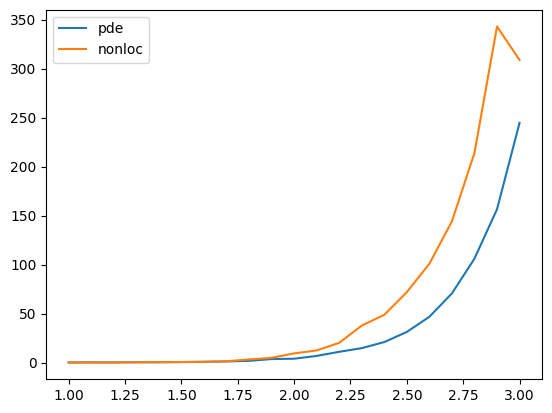

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data1 = pd.read_excel("results.xlsx")
data2 = pd.read_excel("nonloc_results.xlsx")

alpha = data1["alpha"]
st1 = data1["solve time"]
st2 = data2["solve time"]

plt.plot(alpha, st1, label="pde")
plt.plot(alpha, st2, label="nonloc")
plt.legend()
plt.show()

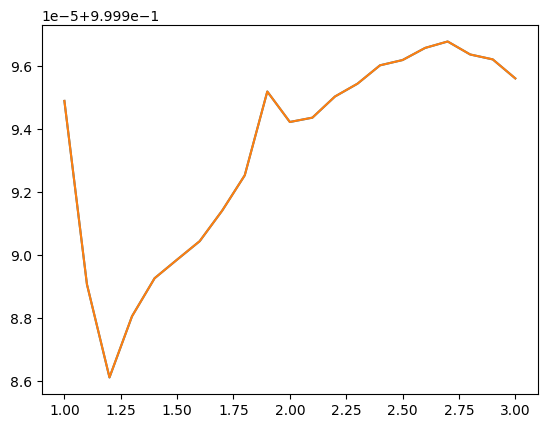

In [4]:
sc1 = data1["score"]
sc2 = data2["score"]

plt.plot(alpha, sc1, label="pde")
plt.plot(alpha, sc2, label="nonloc")